In [1]:
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import os, sys
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# find root directory and add to path
root_index = os.getcwd().rfind('notebooks')
root_directory = os.path.dirname(os.getcwd()[:root_index])
sys.path.append(root_directory)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from MotorNet.plants import RigidTendonArm
from MotorNet.plants.muscles import RigidTendonHillMuscle, RigidTendonHillMuscleThelen
from MotorNet.utils.plotor import plot_pos_over_time
from MotorNet.nets.layers import GRUController
from MotorNet.nets.callbacks import BatchLogger, TrainingPlotter, CustomLearningRateScheduler, TensorflowFix
from MotorNet.tasks import TaskLoadProbability, TaskStaticTarget, TaskDelayedReach, TaskStaticTargetWithPerturbations, TaskDelayedMultiReach

from MotorNet.nets.custommodels import MotorNetModel

%load_ext autoreload
%autoreload 2

# tf.debugging.enable_check_numerics()
print('tensorflow version: ' + tf.__version__)

tensorflow version: 2.6.0


In [2]:
arm = RigidTendonArm(muscle_type=RigidTendonHillMuscleThelen(), timestep=0.01,
                     proprioceptive_delay=0.04, visual_delay=0.09, # 0.04, 0.09 best
                     excitation_noise_sd=1e-4)  # 0.0001 best
visual_feedback_noise = 5e-3 # 5e-3
proprio_feedback_noise = 1e-3 # 1e-3
hidden_noise = 1e-4 # 1e-4
# kernel 1e-6 best
# recurrent 5e-5 best
cell = GRUController(plant=arm, n_units=300, kernel_regularizer=1e-6,
                     recurrent_regularizer=5e-5, name='cell',
                     proprioceptive_noise_sd=proprio_feedback_noise, visual_noise_sd=visual_feedback_noise,
                     hidden_noise_sd=hidden_noise)

delay_range = [10, 990] # 100-1500
target_time_range = [100, 300] # 200-500
do_recompute_targets = True
run_mode = 'train'
cartesian_loss = 1
muscle_loss = 10
vel_weight = 0.0
condition_independent_magnitude = 0.1
background_load = -1
task = TaskLoadProbability(cell, initial_joint_state=np.deg2rad([60., 80., 0., 0.]),
                           delay_range=delay_range,
                           target_time_range=target_time_range,
                           do_recompute_targets=do_recompute_targets,
                           run_mode=run_mode,
                           cartesian_loss=cartesian_loss,
                           muscle_loss=muscle_loss,
                           condition_independent_magnitude=condition_independent_magnitude,
                           background_load=background_load,
                           vel_weight=vel_weight
                           )

# declare inputs
#targets = Input((None, arm.state_dim,), name='target')
inputs = Input((None, task.get_input_dim()), name='inputs')
state0 = [Input((arm.state_dim, ), name='joint0'),
          Input((arm.state_dim, ), name='cartesian0'),
          Input((arm.muscle_state_dim, arm.n_muscles, ), name='muscle0'),
          Input((arm.geometry_state_dim, arm.n_muscles, ), name='geometry0'),
          Input((arm.n_muscles*2, arm.proprioceptive_delay, ), name='proprio_feedback0'),
          Input((arm.space_dim, arm.visual_delay, ), name='visual_feedback0')]
state0.extend([Input((n, ), name='gru' + str(k) + '_hidden0') for k, n in enumerate(cell.n_units)])


# wrap cell in an RNN layer
states_out = tf.keras.layers.RNN(cell=cell, return_sequences=True, name='RNN')(inputs, initial_state=state0)
control_rnn = MotorNetModel(inputs=[inputs, state0], outputs=states_out, name='controller', task=task)
#control_rnn = Model(inputs=[inputs, state0], outputs=states_out)
#control_rnn = MotorNetModel2()

#inputs = Input(shape=(3,))
#x = tf.keras.layers.Dense(4, activation=tf.nn.relu)(inputs)
#outputs = tf.keras.layers.Dense(5, activation=tf.nn.softmax)(x)
#control_rnn = Model(inputs=inputs, outputs=outputs)

# pull the losses from the task itself
[losses, loss_weights] = control_rnn.task.get_losses()

# and compile
control_rnn.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001, clipnorm=1.), loss=losses,
                    loss_weights=loss_weights, run_eagerly=False)
batchlog_callback = BatchLogger()
def scheduler(batch, lr):
        if batch < 50:
            return 0.001
        elif batch == 50:
            return 0.005
        else:
            return lr * tf.math.exp(-0.003)
learningrate_callback = CustomLearningRateScheduler(scheduler, verbose=1)
trainingplot_callback = TrainingPlotter(task, plot_freq=50)
tensorflowfix_callback = TensorflowFix()
control_rnn.summary()
losses

2021-10-06 23:20:35.510199: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-06 23:20:35.510245: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: jonathan-desktop
2021-10-06 23:20:35.510254: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: jonathan-desktop
2021-10-06 23:20:35.510352: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.63.1
2021-10-06 23:20:35.510376: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.63.1
2021-10-06 23:20:35.510383: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.63.1
2021-10-06 23:20:35.510733: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU 

Model: "controller"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None, 7)]    0                                            
__________________________________________________________________________________________________
joint0 (InputLayer)             [(None, 4)]          0                                            
__________________________________________________________________________________________________
cartesian0 (InputLayer)         [(None, 4)]          0                                            
__________________________________________________________________________________________________
muscle0 (InputLayer)            [(None, 6, 6)]       0                                            
_________________________________________________________________________________________

{'cartesian position': <function MotorNet.nets.losses.position_loss.<locals>.loss(y_true, y_pred)>,
 'muscle state': <function MotorNet.nets.losses.activation_velocity_squared_loss.<locals>.loss(y_true, y_pred)>}

In [3]:
cell.layers[1].bias = tf.convert_to_tensor([-5.18, -6.47, -3.63, -6.42, -4.40, -6.48])

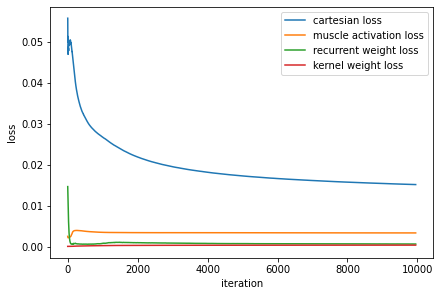

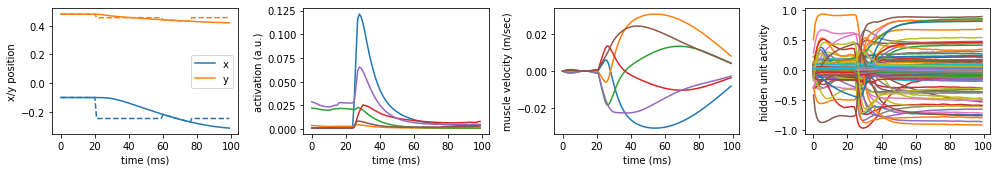

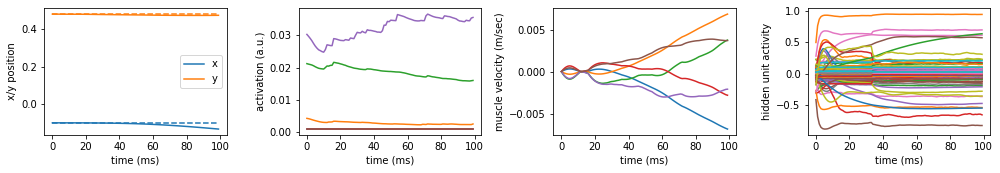

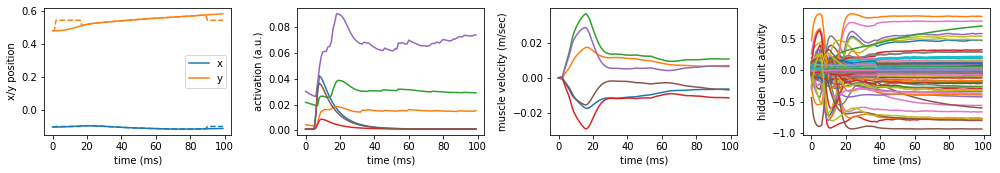

10000/10000 [==============================] - 7874s 786ms/step - loss: 0.0195 - RNN_loss: 0.0151 - RNN_4_loss: 3.3221e-04

In [4]:
#name = 'LoadProb_full_0'
#control_rnn.load_weights('/home/jonathan/Desktop/MotorNetModels/LoadProb/Nets/' + name).expect_partial()

batch_size = 32
n_t = int(1.0 / arm.dt)
control_rnn.task.run_mode = 'train'
control_rnn.task.set_training_params(batch_size=batch_size, n_timesteps=n_t, iterations=10000)
control_rnn.fit(task, verbose=1,
                callbacks=[tensorflowfix_callback, batchlog_callback, trainingplot_callback],
                shuffle=False)

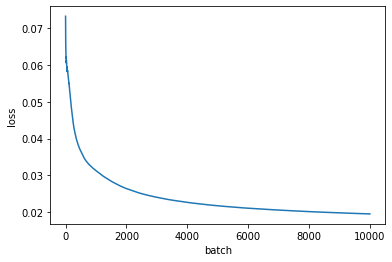

In [5]:
if 'loss' in batchlog_callback.history:
    plt.plot(batchlog_callback.history['loss'])
    plt.xlabel('batch')
    plt.ylabel('loss')
    # plt.semilogy()
    plt.show()


Text(0, 0.5, 'distance to target (y)')

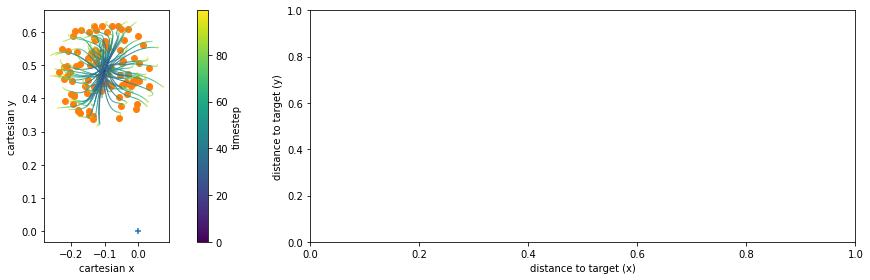

In [6]:
task.run_mode='train'
task.delay_range = np.array([100, 300]) / 1000 / task.plant.dt
import scipy.io
[inputs, targets, init_states] = task.generate(n_timesteps=n_t, batch_size=100)

results = control_rnn([inputs, init_states], training=False)

j_results = results['joint position']
c_results = results['cartesian position']
m_results = results['muscle state']
h_results = results['gru_hidden0']
pro_results = results['proprioceptive feedback']
vis_results = results['visual feedback']
scipy.io.savemat(os.getcwd() + '/saved_models/results.mat', {'joint': j_results.numpy(),
                                                             'cartesian': c_results.numpy(),
                                                             'muscle': m_results.numpy(),
                                                             'inputs': inputs.numpy(),
                                                             'targets': targets.numpy(),
                                                             'neural': h_results.numpy(),
                                                             'proprio': pro_results.numpy(),
                                                             'visual': vis_results.numpy()})

plt.figure(figsize=(16, 4)).set_tight_layout(True)
plt.subplot(121)
plot_pos_over_time(cart_results=c_results)
plt.scatter(targets[:, -1, 0], targets[:, -1, 1])

plt.subplot(122)
#plot_pos_over_time(cart_results=c_results - targets)
plt.xlabel('distance to target (x)')
plt.ylabel('distance to target (y)')

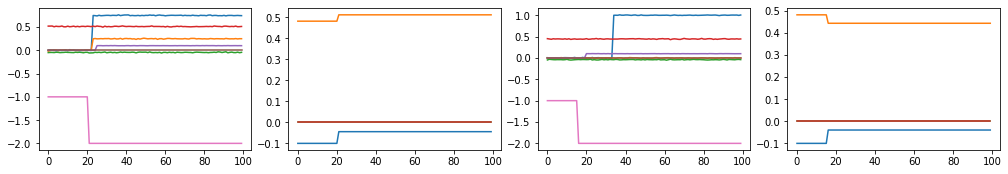

In [7]:
trial = 1
plt.figure(figsize=(14, 2.5)).set_tight_layout(True)

plt.subplot(141)
plt.plot(inputs[0,:,:])

plt.subplot(142)
plt.plot(targets[0,:,:])

plt.subplot(143)
plt.plot(inputs[1,:,:])

plt.subplot(144)
plt.plot(targets[1,:,:])

plt.show()

In [8]:
for trial in range(0):
    plt.figure(figsize=(14, 2.5)).set_tight_layout(True)

    plt.subplot(141)
    plt.plot(j_results[trial, :, 0].numpy().squeeze(), label='sho')
    plt.plot(j_results[trial, :, 1].numpy().squeeze(), label='elb')
    plt.legend()
    plt.xlabel('time (ms)')
    plt.ylabel('angle (rad)')

    plt.subplot(142)
    plt.plot(j_results[trial, :, 2].numpy().squeeze(), label='sho')
    plt.plot(j_results[trial, :, 3].numpy().squeeze(), label='elb')
    plt.legend()
    plt.xlabel('time (ms)')
    plt.ylabel('angle velocity (rad/sec)')

    plt.subplot(143)
    plt.plot(m_results[trial, :, 0, :].numpy().squeeze())
    plt.xlabel('time (ms)')
    plt.ylabel('activation (a.u.)')

    plt.subplot(144)
    plt.plot(m_results[trial, :, 2, :].numpy().squeeze())
    plt.xlabel('time (ms)')
    plt.ylabel('muscle velocity (m/sec)')

    plt.show()

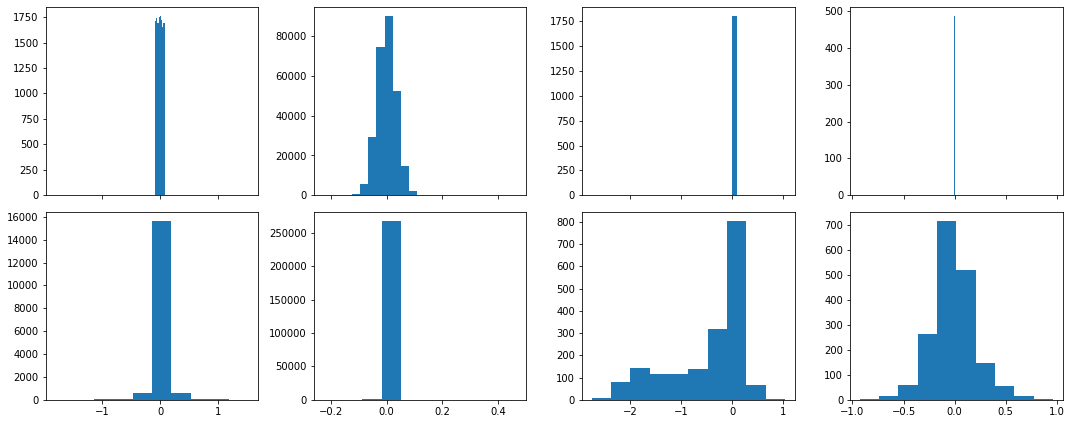

In [9]:
if len(batchlog_callback.weights_log) > 0:
    w0 = batchlog_callback.weights_log[0]
    w1 = batchlog_callback.weights_log[-1]

    fig, axs = plt.subplots(nrows=2, ncols=len(w0), sharex='col')
    fig.set_tight_layout(tight=True)
    fig.set_size_inches((15, 6))

    for n in range(len(w0)):
        weights_ini = w0[n].numpy()
        weights_fin = w1[n].numpy()

        if len(weights_ini.shape) < 10:
            axs[0,n].hist(weights_ini.flatten())
            axs[1,n].hist(weights_fin.flatten())
        else:
            axs[0,n].imshow(weights_ini, interpolation='none')
            axs[1,n].imshow(weights_fin, interpolation='none')

    plt.show()



In [10]:
name = 'test'
### save model
control_rnn.save_model('test')
#C = control_rnn.get_config()
import json


file = open('/home/jonathan/Desktop/MotorNetModels/' + name + '.json', 'r')
newC = json.load(file)


FileNotFoundError: [Errno 2] No such file or directory: '/home/jonathan/Desktop/MotorNetModels/test.json'

In [ ]:
new_rnn = tf.keras.models.load_model('/home/jonathan/Desktop/MotorNetModels/' + name,
                                     custom_objects={'control_rnn': control_rnn})

In [ ]:
task.training_mode=False
task.delay_range = np.array([800, 1100]) / 1000 / task.plant.dt
import scipy.io
[inputs, targets, init_states] = task.generate(n_timesteps=n_t, batch_size=100)

results = new_rnn([inputs, init_states], training=False)

In [ ]:
#from MotorNet.utils.plotor import animate_arm_trajectory

#results_batch_size = tf.shape(j_results)
#to_animate = np.expand_dims(np.transpose(np.reshape(np.transpose(j_results.numpy()), (results_batch_size[2], -1), order='F')), axis=0)

#A = j_results[0:1]

#animate_arm_trajectory(to_animate[:,0:1500,:], arm, path_name = './Arm_animation.gif')
#animate_arm_trajectory(j_results[0:1], arm, path_name = './Arm_animation.gif')


In [ ]:
#from MotorNet.utils.plotor import animate_arm_trajectory
#animate_arm_trajectory(results['joint position'][0:1], arm, path_name = './Arm_animation.gif')


In [ ]:
print([lay.name for lay in C['layers']])
print([lay.name for lay in C['input_layers']])






















